In [1]:
!unzip fashion_mnist_data.zip -d .

Archive:  fashion_mnist_data.zip
  inflating: ./fashion_mnist_data/t10k-images-idx3-ubyte  
  inflating: ./fashion_mnist_data/t10k-labels-idx1-ubyte  
  inflating: ./fashion_mnist_data/train-images-idx3-ubyte  
  inflating: ./fashion_mnist_data/train-labels-idx1-ubyte  


In [2]:
# Imports and Setup
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')  # Clean output

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_curve, auc,
                             ConfusionMatrixDisplay, classification_report)
from sklearn.decomposition import PCA

%matplotlib inline

In [5]:

import numpy as np
import os
from sklearn.model_selection import train_test_split

# Folder name
data_folder = 'fashion_mnist_data'

# Check if files exist
train_images_path = os.path.join(data_folder, 'train-images-idx3-ubyte')
train_labels_path = os.path.join(data_folder, 'train-labels-idx1-ubyte')
test_images_path = os.path.join(data_folder, 't10k-images-idx3-ubyte')
test_labels_path = os.path.join(data_folder, 't10k-labels-idx1-ubyte')

#function to read the ubyte files
def load_mnist_images(path):
    with open(path, 'rb') as f:
        magic = int.from_bytes(f.read(4), 'big')
        num_images = int.from_bytes(f.read(4), 'big')
        rows = int.from_bytes(f.read(4), 'big')
        cols = int.from_bytes(f.read(4), 'big')
        buffer = f.read()
        data = np.frombuffer(buffer, dtype=np.uint8)
        data = data.reshape(num_images, rows * cols)  # Flatten to 784 pixels
    return data

def load_mnist_labels(path):
    with open(path, 'rb') as f:
        magic = int.from_bytes(f.read(4), 'big')
        num_labels = int.from_bytes(f.read(4), 'big')
        buffer = f.read()
        data = np.frombuffer(buffer, dtype=np.uint8)
    return data

# Load your local files
print("Loading your local Fashion-MNIST dataset...")
X_train_full = load_mnist_images(train_images_path)
y_train_full = load_mnist_labels(train_labels_path)
X_test = load_mnist_images(test_images_path)
y_test = load_mnist_labels(test_labels_path)

# Normalize pixels to 0-1
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0

# Combine all data
X = np.vstack((X_train_full, X_test))
y = np.hstack((y_train_full, y_test))

# Keep only first 5 classes (0-4)
mask = y < 5
X = X[mask]
y = y[mask]

# Split into train/validation/test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=5000, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=6000, random_state=42, stratify=y_train_val)

print(f"Training: {X_train.shape[0]}, Validation: {X_val.shape[0]}, Test: {X_test.shape[0]}")
print("Successfully loaded your actual dataset!")

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat']

Loading your local Fashion-MNIST dataset...
Training: 24000, Validation: 6000, Test: 5000
Successfully loaded your actual dataset!


In [6]:
# PCA to reduce to 100 dimensions (speeds up and helps performance)
pca = PCA(n_components=100, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

print(f"Reduced features: {X_train_pca.shape[1]} dimensions")
print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")

Reduced features: 100 dimensions
Explained variance ratio: 0.9360


In [7]:
# Hyperparameter tuning
param_grid = {'C': [0.1, 1, 10], 'solver': ['lbfgs', 'saga']}
logreg = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42)

grid = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_pca, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

# Final model on train + val
best_logreg = grid.best_estimator_
best_logreg.fit(np.vstack((X_train_pca, X_val_pca)), np.hstack((y_train, y_val)))

# Test predictions
y_pred_log = best_logreg.predict(X_test_pca)
acc_log = accuracy_score(y_test, y_pred_log)
print(f"\nLogistic Regression Test Accuracy: {acc_log:.4f}")
print(classification_report(y_test, y_pred_log, target_names=class_names))

Best parameters: {'C': 1, 'solver': 'lbfgs'}
Best CV accuracy: 0.8858750000000001

Logistic Regression Test Accuracy: 0.8848
              precision    recall  f1-score   support

 T-shirt/top       0.91      0.91      0.91      1000
     Trouser       0.98      0.96      0.97      1000
    Pullover       0.84      0.80      0.82      1000
       Dress       0.86      0.88      0.87      1000
        Coat       0.83      0.87      0.85      1000

    accuracy                           0.88      5000
   macro avg       0.89      0.88      0.88      5000
weighted avg       0.89      0.88      0.88      5000



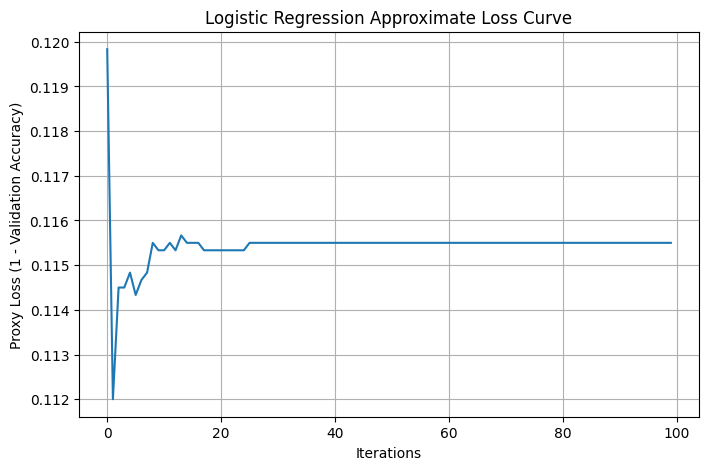

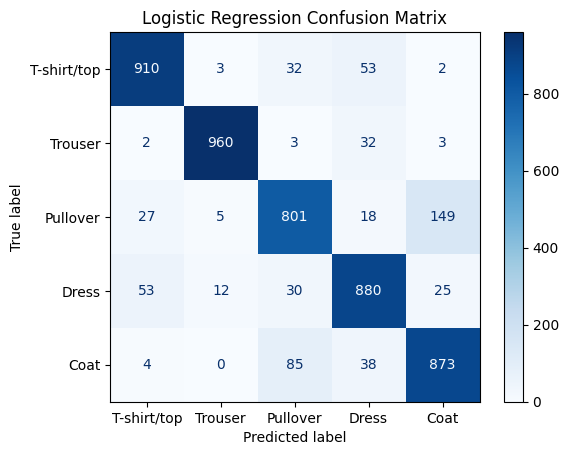

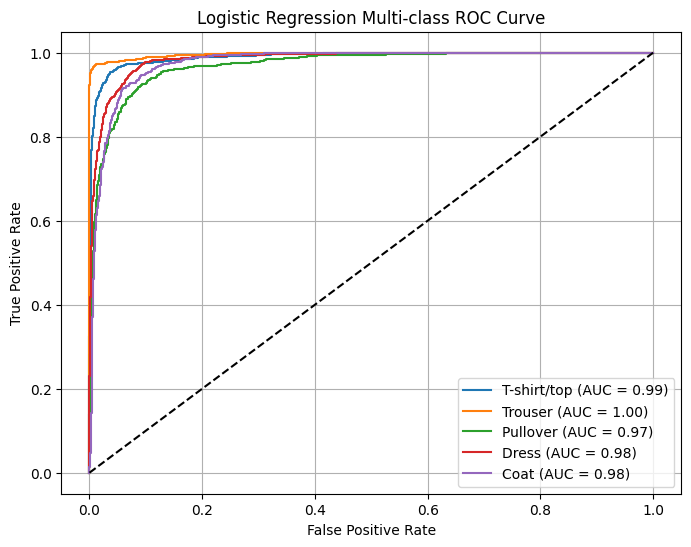

In [8]:
# Loss curve approximation (using partial fits with saga)
losses = []
logreg_partial = LogisticRegression(multi_class='multinomial', solver='saga',
                                    C=grid.best_params_.get('C', 1.0),
                                    max_iter=1, warm_start=True, random_state=42)

for epoch in range(1, 101):
    logreg_partial.max_iter = epoch
    logreg_partial.fit(X_train_pca, y_train)
    val_acc = logreg_partial.score(X_val_pca, y_val)
    losses.append(1 - val_acc)  # Proxy loss: 1 - accuracy

plt.figure(figsize=(8,5))
plt.plot(losses)
plt.title('Logistic Regression Approximate Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Proxy Loss (1 - Validation Accuracy)')
plt.grid(True)
plt.show()

# Confusion Matrix
cm_log = confusion_matrix(y_test, y_pred_log)
ConfusionMatrixDisplay(cm_log, display_labels=class_names).plot(cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

# Multi-class ROC (One-vs-Rest)
y_test_bin = pd.get_dummies(y_test)
y_score = best_logreg.predict_proba(X_test_pca)

plt.figure(figsize=(8,6))
for i in range(5):
    fpr, tpr, _ = roc_curve(y_test_bin.iloc[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('Logistic Regression Multi-class ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Fit K-Means
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, random_state=42)
kmeans.fit(X_train_pca)

# Map clusters to labels (majority vote)
cluster_map = {}
for cluster in range(5):
    mask_cluster = (kmeans.labels_ == cluster)
    if mask_cluster.sum() > 0:
        cluster_map[cluster] = np.bincount(y_train[mask_cluster]).argmax()

print("Cluster to label mapping:", cluster_map)

# Predict test
cluster_pred = kmeans.predict(X_test_pca)
y_pred_kmeans = np.array([cluster_map.get(c, 0) for c in cluster_pred])  # fallback to 0 if empty

acc_kmeans = accuracy_score(y_test, y_pred_kmeans)
print(f"\nK-Means Test Accuracy: {acc_kmeans:.4f}")
print(classification_report(y_test, y_pred_kmeans, target_names=class_names))

Cluster to label mapping: {0: np.int64(0), 1: np.int64(1), 2: np.int64(2), 3: np.int64(0), 4: np.int64(4)}

K-Means Test Accuracy: 0.5310
              precision    recall  f1-score   support

 T-shirt/top       0.43      0.93      0.59      1000
     Trouser       0.63      0.85      0.73      1000
    Pullover       0.59      0.39      0.47      1000
       Dress       0.00      0.00      0.00      1000
        Coat       0.59      0.48      0.53      1000

    accuracy                           0.53      5000
   macro avg       0.45      0.53      0.46      5000
weighted avg       0.45      0.53      0.46      5000



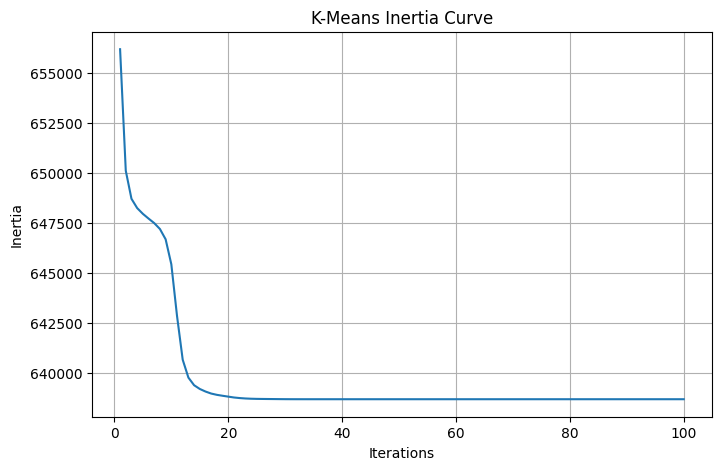

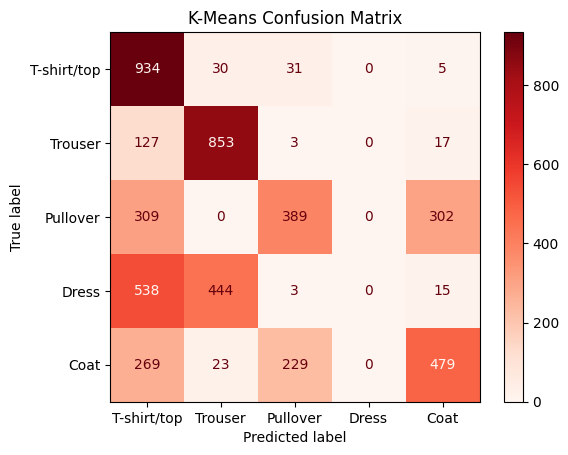

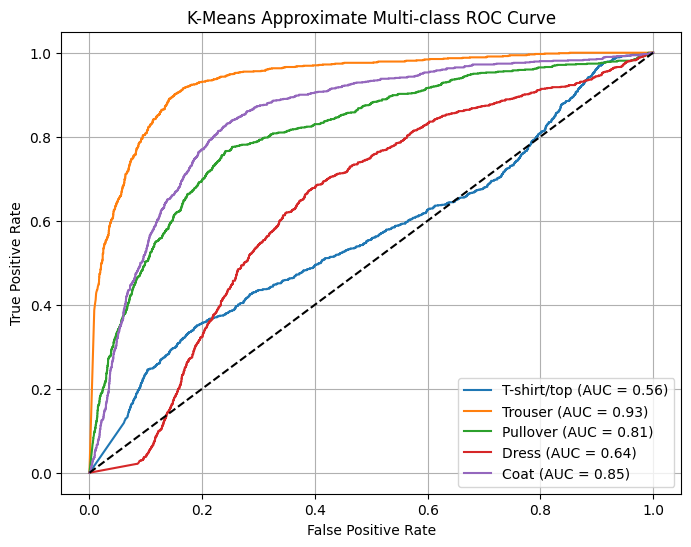

In [10]:
# Inertia curve
inertias = []
ks = range(1, 101)
for i in ks:
    km = KMeans(n_clusters=5, max_iter=i, random_state=42)
    km.fit(X_train_pca)
    inertias.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(ks, inertias)
plt.title('K-Means Inertia Curve')
plt.xlabel('Iterations')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

# Confusion Matrix
cm_km = confusion_matrix(y_test, y_pred_kmeans)
ConfusionMatrixDisplay(cm_km, display_labels=class_names).plot(cmap='Reds')
plt.title('K-Means Confusion Matrix')
plt.show()

# Approximate ROC using distance-based scores
dists = kmeans.transform(X_test_pca)
scores_km = np.exp(-dists**2)  # Similarity scores
scores_km /= scores_km.sum(axis=1, keepdims=True)

plt.figure(figsize=(8,6))
for i in range(5):
    fpr, tpr, _ = roc_curve(y_test_bin.iloc[:, i], scores_km[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('K-Means Approximate Multi-class ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()